<a href="https://colab.research.google.com/github/KacperGrodecki/image_proccessing/blob/main/kuba_img_text_reading_found_words_analyzing_enchant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pyenchant

In [3]:
!apt install -qq enchant

enchant is already the newest version (1.6.0-11.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
!apt-get install myspell-pl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
myspell-pl is already the newest version (20170707-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
import pandas as pd
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt      
import pickle
from os import listdir
from os.path import isfile, join
import gc
import sys
import pickle
import string
import enchant

In [6]:
d = enchant.Dict('PL')
d.check("guzik") # False



True

In [7]:
text=pd.read_csv('drive/MyDrive/kuba/odczyt_0_85.csv',index_col=0)

In [8]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [65]:
def word_correction_enchant(a):
    a=str(a)
    correct=''
    for word in a.split():
        if len(word)>1:
            if word.isnumeric() or len(word)<3:
              continue
            try:
              if int(d.check(word))==1:
                correct+=word.lower()+' '
            except:
              pass     
    return correct

In [66]:
correct=text.applymap(lambda x: word_correction_enchant(x))

In [83]:
correct.head(20)

,0
0,
1,własność archiwum tytuł teczki daty skrajne je...
2,ipn
3,karta informacyjna
4,instytut pamięci narodowej warszawie
5,
6,msw
7,tytuł teczki
8,pax- materiały dotyczące działalności zrzeszenia
9,daty skrajne


In [84]:
correct1 = correct[correct['0']!= '']

In [14]:
pip install spacy==2.3.2

In [15]:
!python3 -m spacy download pl_core_news_md
#https://github.com/explosion/spaCy/issues/5140

     |████████████████████████████████| 79.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')


In [85]:
import spacy  
from spacy.lang.pl.examples import sentences 

In [ ]:
#https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [86]:
nlp = spacy.load("pl_core_news_md")

In [87]:
df=correct1.copy()

In [88]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [121]:
brief_cleaning = (re.sub("[^A-Źa-Ź']+", ' ', str(row)).lower() for row in df['0'])

In [90]:
from time import time

In [122]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.12 mins


In [123]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(4362, 1)

In [93]:
from gensim.models.phrases import Phrases, Phraser

In [124]:
sent = [row.split() for row in df_clean['clean']]

In [125]:
phrases = Phrases(sent, min_count=5, progress_per=100)

In [126]:
bigram = Phraser(phrases)

In [127]:
sentences = bigram[sent]

In [98]:
from collections import defaultdict  # For word frequency

In [128]:
df_clean

,clean
0,własność archiwum tytuł teczka data skrajny je...
3,instytut pamięć narodowy warszawa
6,pax materiał dotyczyć działalność zrzeszenie
13,struktura wykonanie buda etów
14,katolicki organizacja społeczny
...,...
9488,stan nauka religia punkt
9489,brak inicjatywa księ y zakres usprawnienie
9491,środa katolik świecki
9492,rozkład spowodować brak pro


In [129]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

4912

In [130]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['praca',
 'pax',
 'działalność',
 'człowiek',
 'stowarzyszenie',
 'sprawa',
 'rozwój',
 'nale_y',
 'swój',
 'polityczny',
 'kraj',
 'e',
 'nowy',
 'polski',
 'mo_e',
 'kościół',
 'rola',
 'społeczny',
 'dzień',
 'wartość']

In [101]:
import multiprocessing

from gensim.models import Word2Vec

In [131]:
cores = multiprocessing.cpu_count()

In [132]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [133]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [134]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.05 mins


In [135]:
w2v_model.init_sims(replace=True)

In [136]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['praca',
 'pax',
 'działalność',
 'człowiek',
 'stowarzyszenie',
 'sprawa',
 'rozwój',
 'nale_y',
 'swój',
 'polityczny',
 'kraj',
 'e',
 'nowy',
 'polski',
 'mo_e',
 'kościół',
 'rola',
 'społeczny',
 'dzień',
 'wartość']

In [137]:
w2v_model.wv.most_similar(positive=["pax"])

[('kraj', 0.7646898031234741),
 ('praca', 0.7601364850997925),
 ('sprawa', 0.741675853729248),
 ('sytuacja', 0.7364075183868408),
 ('dzień', 0.7302334904670715),
 ('rozwój', 0.683314323425293),
 ('wyra', 0.6794366836547852),
 ('wygłosić', 0.6625482439994812),
 ('kultura', 0.6603901982307434),
 ('rola', 0.6565902829170227)]

In [138]:
w2v_model.wv.most_similar(negative=["pax"])

[('prasa', -0.09120777994394302),
 ('ycia', -0.11271914839744568),
 ('występować', -0.11464180797338486),
 ('dać', -0.11983178555965424),
 ('narodowy', -0.13283982872962952),
 ('zebranie', -0.19118304550647736),
 ('być', -0.2042551338672638),
 ('teza', -0.21220260858535767),
 ('ju', -0.21667876839637756),
 ('świat', -0.2212044894695282)]

In [139]:
w2v_model.wv.doesnt_match(['pax', 'socjalizm', 'chrze_cija'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'pax'

In [140]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [144]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [142]:
sorted(word_freq, key=word_freq.get, reverse=True)[:20]

['praca',
 'pax',
 'działalność',
 'człowiek',
 'stowarzyszenie',
 'sprawa',
 'rozwój',
 'nale_y',
 'swój',
 'polityczny',
 'kraj',
 'e',
 'nowy',
 'polski',
 'mo_e',
 'kościół',
 'rola',
 'społeczny',
 'dzień',
 'wartość']

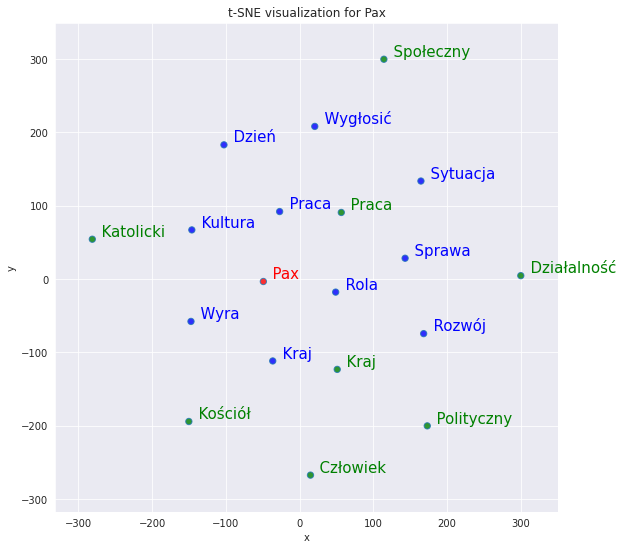

In [149]:
tsnescatterplot(w2v_model, 'pax', ['praca', 'działalność', 'człowiek', 'polityczny', 'kraj', 'kościół', 'społeczny','katolicki'])